# Coding Controllers with Python Generators

Up to this point we have been implementing simple control strategies where the manipulated variable depends only on current values of the process variable and setpoint. Relay control, for example, can be expressed mathematically as

$$MV = Kp \times (SP - PV)$$

and implemented in Python as

    def proportional(PV,SP):
        MV = Kp * (SP - PV)
        return MV

Python functions carry no persistent memory from one use to the next, which is fine if the control algorithm requires no knowledge of the past.

The problem, however, is that more useful control algorithms require use of past measurements. Proportional-integral control, for example, tracks the cumulative sum of the differences between setpoint and the process variable. Because a Python function disappears completely after the return statement, the value of the cumulative sum must be stored somewhere in code. The coding problem is to figure out how and where to store that information between calls to the algorithm. We seek coding methods that encapsulate the state of control algorithms.

There are several ways this can be done in Python (roughly in order of increasing capability and complexity):

* Generators written using the Python `yield` statement
* Classes
* Asynchronous programming with co-routines
* Threads

Classes, in particular, are a tool for encapsulating data and functionality within a single software entity. Classes are widely used in Python programming, and should eventually become part of every Python programmer's toolkit.

As we demonstrate below, however, the Python `yield` statement is often sufficient to write self-contained implementations of control algorithm. 

## Python Generators and the Yield Statement

The cells below provide a very brief introduction to Python generators. More information can be found [here](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/)

A function incorporating a `yield` statement is used to create generators.  Like the `return` statement, `yield` says to return a value and control to the calling routine. But unlike the `return` statement, following a `yield` the generator goes into a suspended state. On the next use it will pick up execution right where execution left off.

Here's an example produces a generator for four numbers.

In [1]:
def numbers_gen():
    yield 0
    yield 1
    yield 2.7182818
    yield 3.1415926

To use this, first create the actual generator object that will do the work. 

In [2]:
numbers = numbers_gen()

The generator object `numbers` has a `send` method for sending information to the generator and causing it to execute until the next `yield`.  For this case all we need to send is `None`.

In [3]:
print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))

0
1
2.7182818
3.1415926


The `send` method provides two-way communication with a generator. Here's an example of how that works.

In [5]:
def texter_gen():
    a = yield "Started"
    b = yield a
    
texter = texter_gen()
print(texter.send(None))
print(texter.send("Hello, World"))

Started
Hello, World


There's a subtle detail here that easy to miss. The first `send` starts the generator which then executes up to the first yield statement. At that point execution halts and the message "Started" is sent to the calling routine. The second `send` causes execution to pick up again and puts the message "Hello, World" into variable `a`.  

An important point is that the first `send` to a generator must always be `None`.

In the next example `yield` is placed inside an infinite loop. This function creates generators that return the square of the number sent.

In [6]:
# A function that will create generators
def our_numbers():
    n = 0
    while True:
        n = yield n*n

# create a generator
numbers = our_numbers()

# start the generator
numbers.send(None)        

# send values to the generator and print the results
print(numbers.send(4))
print(numbers.send(12))
print(numbers.send(42))

# how to remove a generator when finished using it.
numbers.close()

16
144
1764


Let's now consider how generators may be used for process control applications. The next cell defines a function that will create generators that perform as proportional controllers with specified gain $K_p$ and setpoint $SP$. When sent a current value of the process variable `PV`, the controllers will return a value for the manipulated variable `MV`.

In [7]:
def proportional(Kp, SP):
    """Creates proportional controllers with specified gain and setpoint."""
    MV = 0
    while True:
        PV = yield MV
        MV = Kp * (SP - PV)

Let's create and initialize two controllers with the same setpoint but different gains.

In [8]:
controller1 = proportional(10, 40)
controller1.send(None)

controller2 = proportional(1, 40)
controller2.send(None)

0

Let's see how these controllers would respond to a PV value of 35.

In [9]:
PV = 35

print("Controller 1: MV = ", controller1.send(PV))
print("Controller 2: MV = ", controller2.send(PV))

Controller 1: MV =  50
Controller 2: MV =  5


From a coding and maintenance perspective, this is a very useful feature. We need to create and maintain only one copy of the control algorithm.

## Example: Relay Control with Hysteresis

Relay control can work well but is sensitive to measurement noise. Even a relatively small amount of measurement noise causes the manipulated variable to rapidly cycle between extreme values. Needless to say, this would be a unacceptable in large scale chemical plants.

A common workaround is add a small amount of hystersis to the controller. Here's an example from the Inkbird IB-16 controller that is typical of a commercial devices found in the food and pharaceutical industries.

<img src='images/Inkbird-16.png' style="float: left;padding-right:10px;"></img>
<img src='images/Inkbird-16-Manual.png' style="float: right;padding-left:30px;"></img>

The controller is modeled

$$MV_k = \begin{cases} 100 & \mbox{if }PV_k \leq SP - d \\ 0 & \mbox{if }PV_k \geq SP + d \\ MV_{k-1}\end{cases}$$

where $SP \pm d$ is the range over which the manipulated variable is left unchanged.

This can be coded as follows

In [10]:
def relay(d, SP):
    MV = 0
    while True:
        PV = yield MV
        MV_prev = MV
        MV = 100 if PV < SP - d else 0 if PV > SP + d else MV_prev

### Simulation

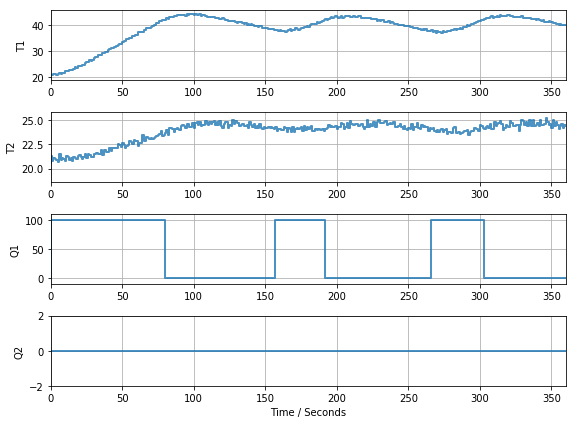

Surrogate TCLab disconnected successfully.


In [11]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

thermostat = relay(2,40)    # create thermostat
thermostat.send(None)       # initialize thermostat

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h, twindow=360)
    for t in clock(360):
        PV = a.T1                         # get measurements
        MV = thermostat.send(PV)          # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

### Experiment

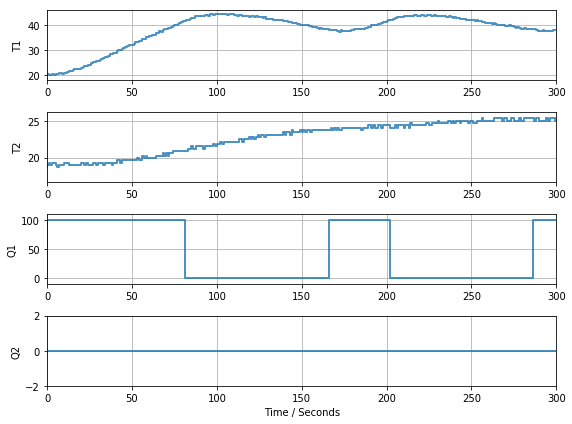

TCLab disconnected successfully.


In [12]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=True, speedup=1)

thermostat = relay(2,40)    # create thermostat
thermostat.send(None)       # initialize thermostat

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h,twindow=300)
    for t in clock(300, strict=False):
        PV = a.T1                         # get measurements
        MV = thermostat.send(PV)          # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

## Example: Proportional-Integral Control

A simple velocity form of Proportional-Integral control is an example of a controller with internal state. In velocity form,

$$MV_{k} = MV_{k-1} + K_p (e_k - e_{k-1}) + K_iT_se_k$$

where $e_k$ is the difference between setpoint and measured process variable

$$e_k = SP_k - PV_k$$

$K_p$ and $K_i$ are control constants, and $T_s$ is the sampling time. To prevent windup of the integral term, a PI algorithm will typically enforce upper and lower bounds on the value of $MV$. 

The following cell provides a direct implementation of this algorithm as a Python generator.

In [13]:
def PI(Kp, Ki, b=1):
    """Proportional Integral Control."""
    t = 0
    e = 0
    MV = 0
    while True:
        # store prior values before yielding
        t_prev = t
        e_prev = e
        MV_prev = MV
        
        # yield
        PV, SP, t = yield MV

        # PI control algorithm
        e = b*SP - PV
        MV = MV_prev + Kp*(e - e_prev) + Ki*(t - t_prev)*(SP - PV)
        
        # prevent integral windup
        MV = max(0, min(100, MV))

### Simulation

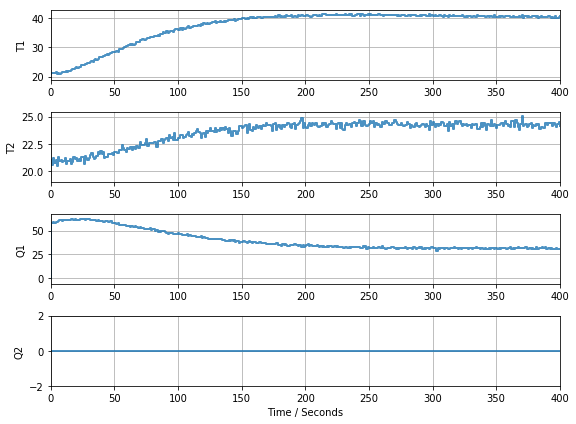

Surrogate TCLab disconnected successfully.


In [14]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

controller = PI(3, 0.03)    # create thermostat
controller.send(None)       # initialize thermostat

SP = 40

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h, twindow=400)
    for t in clock(400):
        PV = a.T1                         # get measurements
        MV = controller.send([PV,SP,t])   # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

### Experiment

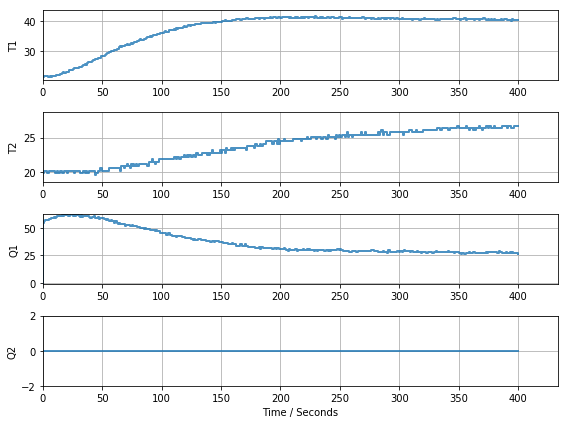

TCLab disconnected successfully.


In [16]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=True)

controller = PI(3, 0.03)    # create thermostat
controller.send(None)       # initialize thermostat

SP = 40

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h, twindow=400)
    for t in clock(400, tol=0.5):
        PV = a.T1                         # get measurements
        MV = controller.send([PV,SP,t])   # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display